In [91]:
using MAT
using NPZ
using Glob
using WebIO
using PyPlot
using Eirene
using Random
using Statistics
using Clustering

rng = MersenneTwister(1337);

#### Load data

In [92]:
filelist = glob("EGF(E6)w*.mat", "experimental-data")
sz = size(filelist)[1];

well_nums = []
particle_pos = []

for i in 1:sz
    
    filenamewext = split(filelist[i], '/')[2]
    filename = split(filenamewext, '.')[1]
    well_num = parse(Int, split(filename, 'w')[2])
    
    mat_variables = matread(filelist[i])
    pos_x = mat_variables["storeX"]
    pos_y = mat_variables["storeY"]
    pos_x_final = pos_x[1:end, size(pos_x)[2]]
    pos_y_final = pos_y[1:end, size(pos_y)[2]]
    pos_x_final = filter!(!(isnan), pos_x_final)
    pos_y_final = filter!(!(isnan), pos_y_final)
    pos_final = hcat(pos_x_final, pos_y_final)
    pos_final = transpose(pos_final)
    
    push!(well_nums, well_num)
    push!(particle_pos, pos_final)
    
end

#### Sort by well number

In [93]:
sort_idx = sortperm(well_nums)
well_nums = well_nums[sort_idx];
particle_pos = particle_pos[sort_idx];

densities = [500, 500, 500, 1000, 1000, 1000, 
             1000, 1000, 1000, 500, 500, 500,
             500, 500, 500, 1000, 1000, 1000,
             1000, 1000, 1000, 500, 500, 500];

conditions = ["GM", "Gefitinib", "Assay", "GM", "Gefitinib", "Assay",
             "Assay", "Gefitinib", "GM", "Assay", "Gefitinib", "GM",
             "GM", "Gefitinib", "Assay", "GM", "Gefitinib", "Assay",
             "Assay", "Gefitinib", "GM", "Assay", "Gefitinib", "GM"];

#### Plot experimental condition

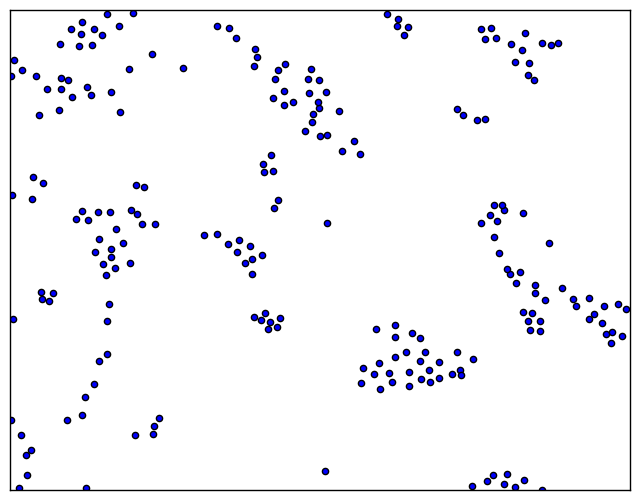

Well 6 Assay 1000 cells
Number of cells 228

In [94]:
cnt = 6
print("Well " * string(well_nums[cnt]) * " " * conditions[cnt] * " " * string(densities[cnt]) * " cells\n");
print("Number of cells " * string(size(particle_pos[cnt])[2]));
scatter(particle_pos[cnt][1,:],particle_pos[cnt][2,:]);
xticks([]);
xlim([0, 900]);
ylim([0, 900]);
yticks([]);

In [203]:
function get_pos(well_num, time)
    
    @assert 1 < time
    @assert time <= 249
    
    pathstring = "experimental-data/EGF(E6)w" * string(well_num) * ".mat"
    mat_variables = matread(pathstring)
    pos_x = mat_variables["storeX"]
    pos_y = mat_variables["storeY"]
    pos_x_t = pos_x[1:end, time]
    pos_y_t = pos_y[1:end, time]
    pos_x_t = filter!(!(isnan), pos_x_t)
    pos_y_t = filter!(!(isnan), pos_y_t)
    max_lim = maximum([maximum(pos_x_t), maximum(pos_y_t)])
    min_lim = minimum([minimum(pos_x_t), minimum(pos_y_t)])
    pos_x_t = -10 .+ 20*((pos_x_t .- min_lim)./(max_lim - min_lim))
    pos_y_t = -10 .+ 20*((pos_y_t .- min_lim)./(max_lim - min_lim))
    pos_t = hcat(pos_x_t, pos_y_t)
    pos_t = transpose(pos_t)
    
end

get_pos (generic function with 1 method)

In [206]:
#spanning_well_23 = particle_pos[11];    # t = 249, 268 particles
#spanning_well_54 = particle_pos[18];    # t = 249, 275 particles
#clustered_well_6 = particle_pos[6];     # t = 249, 228 particles
#clustered_well_19 = particle_pos[7];    # t = 249, 284 particles 
#individual_well_4 = get_pos(4, 130);    # t = 130, 257 particles
#individual_well_69 = get_pos(21, 130);  # t = 130, 262 particles

spanning_well_5 = get_pos(5, 151);     # 200 cells (1000 density)
spanning_well_20 = get_pos(20, 129);   # 201 cells (1000 density)
clustered_well_6 = get_pos(6, 168);    # 200 cells (1000 density)
clustered_well_19 = get_pos(19, 119);  # 200 cells (1000 density)
individual_well_4 = get_pos(4, 103);   # 197 cells (1000 density)
individual_well_69 = get_pos(69, 112); # 204 cells (1000 density)

#### Plot normalized positions with random particle removal

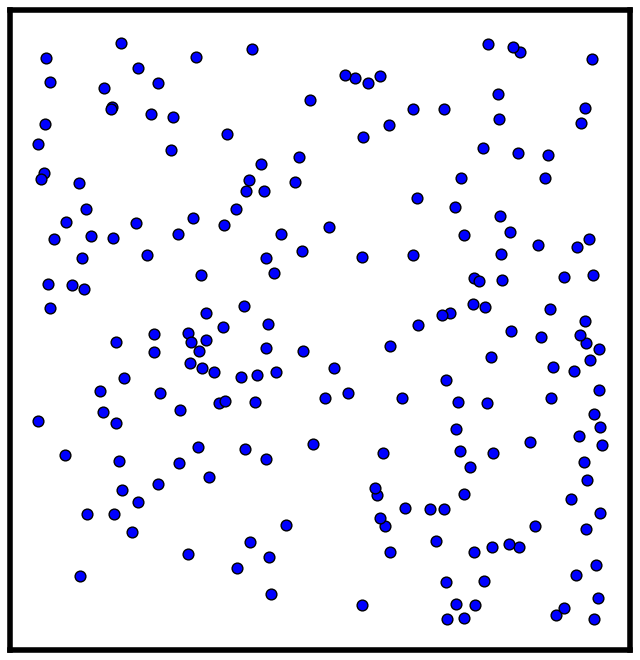

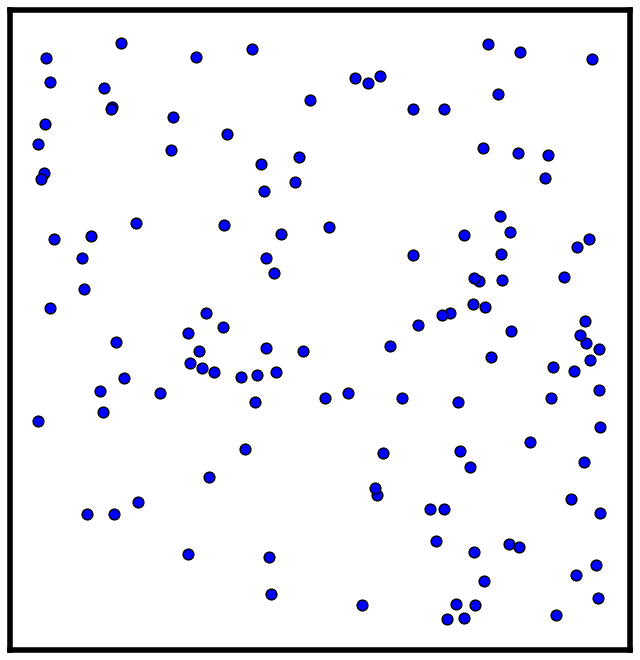

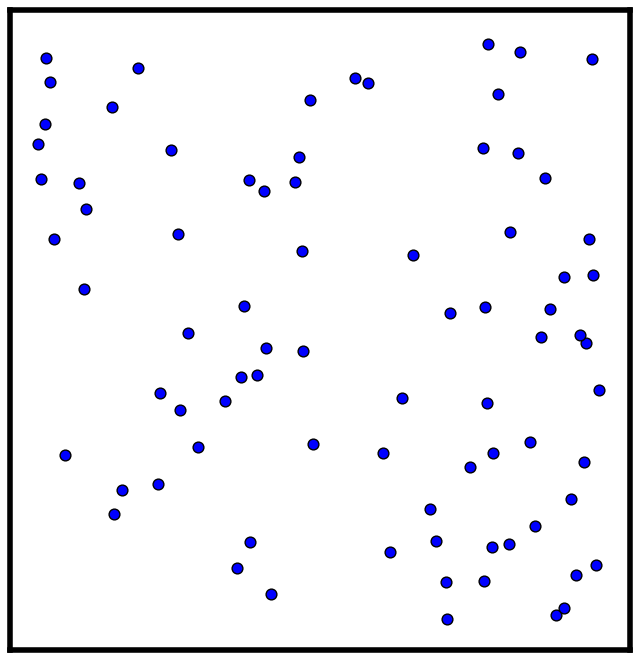

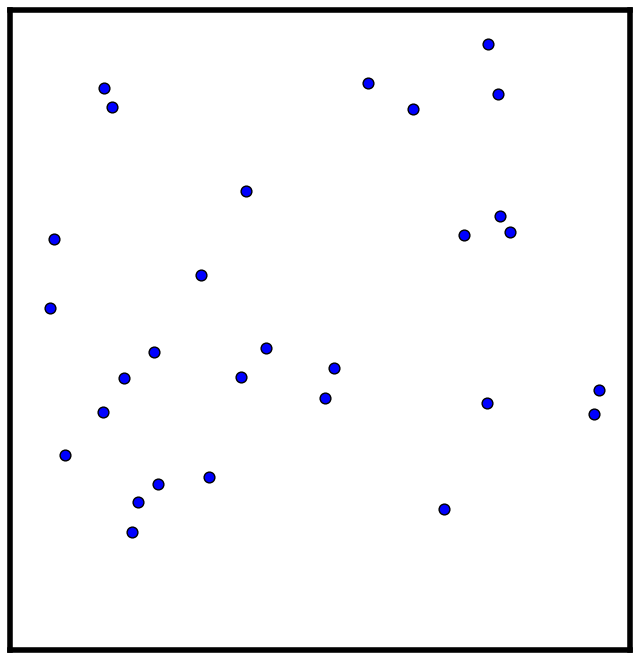

In [221]:
function plot_removals(pos_data, removals)
    num_particles = size(pos_data)[2]
    for num_removals in removals
        permutation = randperm(rng, num_particles)
        keep_idx = permutation[1:(num_particles-num_removals)]
        pos_tmp = pos_data[:, keep_idx]
        figure(figsize=(8,8), dpi=600)
        scatter(pos_tmp[1,:], pos_tmp[2,:], s=60)
        xticks([])
        yticks([])
        xlim([-11, 11])
        ylim([-11, 11])
        ax = gca()
        ax.spines["bottom"].set_linewidth(4)
        ax.spines["top"].set_linewidth(4)
        ax.spines["left"].set_linewidth(4)
        ax.spines["right"].set_linewidth(4)
        show()
    end
end


plot_removals(individual_well_69, [0, 75, 125, 175])

#### Compute change in Wasserstein distance with random particle removal

In [207]:
function random_particle_removal(pos, num_removals, num_repetitions)
    
    num_cells = size(pos)[2]
    
    wasserstein_distances = Array{Float64}(undef, num_removals, num_repetitions);
    
    ref_pers_diag = eirene(pos, model="pc", maxdim=1)
    ref_barcode = barcode(ref_pers_diag)
    
    for i in 1:num_removals
        
        for rep in 1:num_repetitions
       
            permutation = randperm(rng, num_cells)
            keep_idx = permutation[1:(num_cells-i)]
            pos_tmp = pos[:,keep_idx]
            pers_diag_tmp = eirene(pos_tmp, model="pc", maxdim=1)
            barcode_tmp = barcode(pers_diag_tmp)
            wasserstein_distances[i, rep] = wasserstein_distance(barcode_tmp, ref_barcode, q=2, p=2)
            
        end
        
    end
    
    return(wasserstein_distances)
    
end

random_particle_removal (generic function with 2 methods)

In [208]:
num_removals = 180;
num_repetitions = 5;

spanning_well_5_wass = random_particle_removal(spanning_well_5, num_removals, num_repetitions);
spanning_well_5_label = "DMSO, Gefitinib, 1000 cells (Well 5, Spanning)";

spanning_well_20_wass = random_particle_removal(spanning_well_20, num_removals, num_repetitions);
spanning_well_20_label = "DMSO, Gefitinib, 1000 cells (Well 20, Spanning)";

clustered_well_6_wass = random_particle_removal(clustered_well_6, num_removals, num_repetitions);
clustered_well_6_label = "DMSO, Assay, 1000 cells (Well 6, Clustered)";

clustered_well_19_wass = random_particle_removal(clustered_well_19, num_removals, num_repetitions);
clustered_well_19_label = "DMSO, Assay, 1000 cells (Well 19, Clustered)";

individual_well_4_wass = random_particle_removal(individual_well_4, num_removals, num_repetitions);
individual_well_4_label = "DMSO, GM, 1000 cells (Well 4, Individual)";

individual_well_69_wass = random_particle_removal(individual_well_69, num_removals, num_repetitions);
individual_well_69_label = "OHT, GM, 1000 cells (Well 69, Individual)";

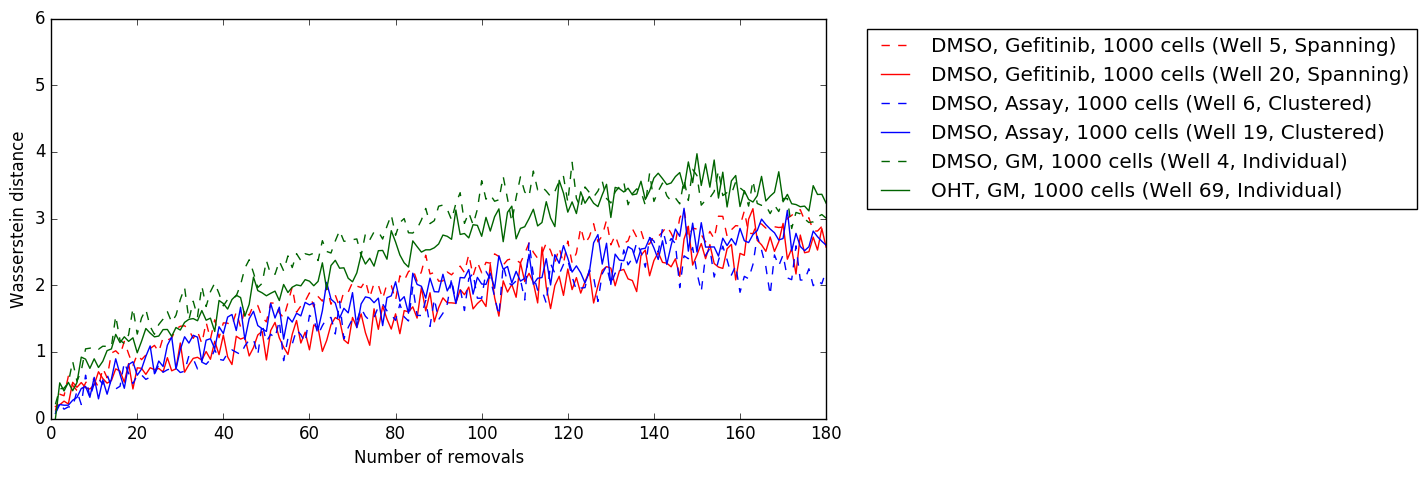

In [216]:
figure(figsize=(10,5))

plot(1:num_removals, mean(spanning_well_5_wass, dims=2), label=spanning_well_5_label, color=:red, "--")
plot(1:num_removals, mean(spanning_well_20_wass, dims=2), label=spanning_well_20_label, color=:red, "-")

plot(1:num_removals, mean(clustered_well_6_wass, dims=2), label=clustered_well_6_label, color=:blue, "--")
plot(1:num_removals, mean(clustered_well_19_wass, dims=2), label=clustered_well_19_label, color=:blue, "-")

plot(1:num_removals, mean(individual_well_4_wass, dims=2), label=individual_well_4_label, color=:darkgreen, "--")
plot(1:num_removals, mean(individual_well_69_wass, dims=2), label=individual_well_69_label, color=:darkgreen, "-")

xlabel("Number of removals")
ylabel("Wasserstein distance")
ylim([0, 6])
legend(bbox_to_anchor=(1.04, 1), loc = "upper left");

#### Compute peristence diagrams and barcodes

In [48]:
@time begin

    barcodes = []

    for i in 1:sz
        pers_diag = eirene(particle_pos[i], model="pc", maxdim=1)
        push!(barcodes, barcode(pers_diag))
    end
    
end

 46.776207 seconds (135.74 M allocations: 28.295 GiB, 10.63% gc time)


#### Compute pairwise Wasserstein distances

In [49]:
@time begin
    
    wassmatrix = Array{Float64}(undef, sz, sz);
    for rows in 1:sz
        for cols in 1:sz
            wassmatrix[rows, cols] = wasserstein_distance(barcodes[rows], barcodes[cols], q=2, p=2);
        end
    end
    
end

 77.979330 seconds (532.90 k allocations: 718.178 MiB, 0.05% gc time)


In [50]:
npzwrite("Exp_Wasserstein_Pairwise.npy", wassmatrix)

In [66]:
well_names = []

for i in 1:sz
    treat = ""
    if well_nums[i] < 25
        treat = treat * "DMSO, "
    else
        treat = treat * "OHT, "
    end
    push!(well_names, treat * conditions[i] * ", " * string(densities[i]) * " cells")
end

#### Plot heatmap

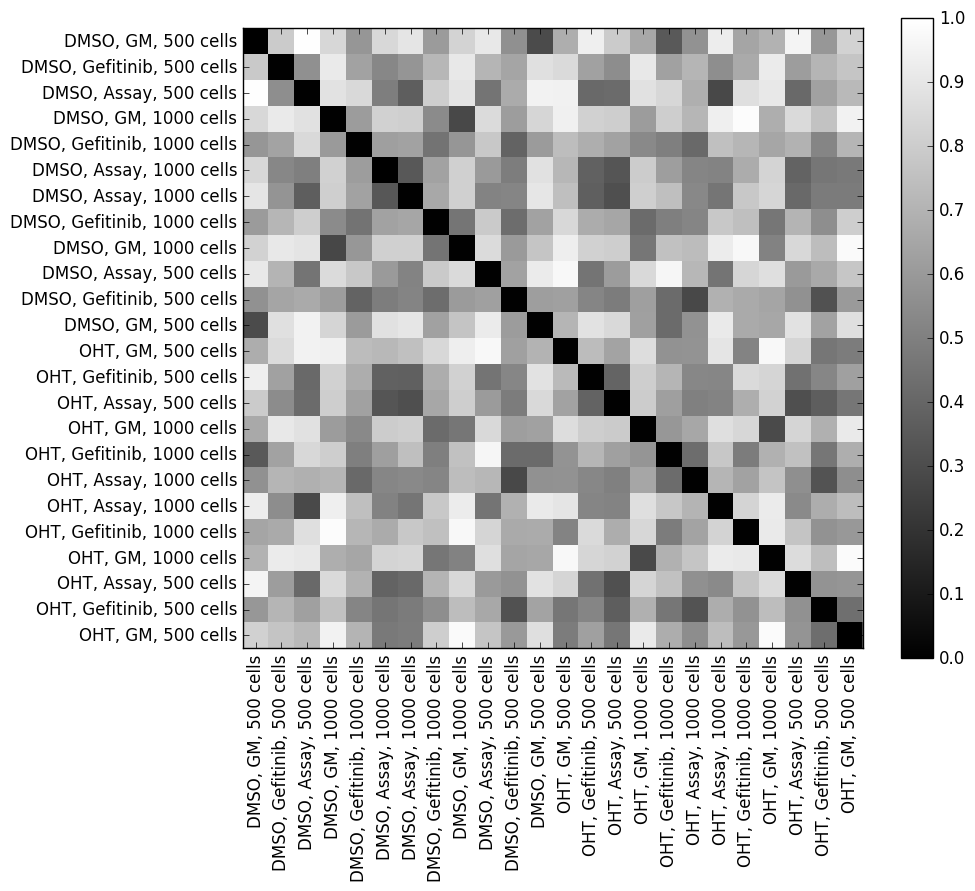

In [67]:
max_coord = maximum(wassmatrix)
wassmatrix = wassmatrix/max_coord

figure(figsize=(10,8), dpi=300);
imshow(wassmatrix, cmap="gray", interpolation="none");
xticks(0:sz-1, well_names, rotation=90);
yticks(0:sz-1, well_names);
colorbar();

In [53]:
hclust_res = hclust(wassmatrix, linkage=:complete, uplo=:U)

Hclust{Float64}([-4 -9; -11 -18; … ; 16 20; 21 22], [0.27958415142874804, 0.2820108087713452, 0.2829332618749553, 0.29240442690326, 0.29416293531431004, 0.3107445965920265, 0.3269746528082269, 0.34563248612028385, 0.383417455189077, 0.4202750506505168  …  0.48683567578941195, 0.5555333224589709, 0.5974192565562002, 0.6100879856119937, 0.6427495058542566, 0.6798061137405187, 0.7099598189959678, 0.8451843285001054, 0.9765418641278918, 1.0], [17, 1, 12, 23, 11, 18, 5, 8, 4, 9  …  24, 2, 15, 22, 14, 6, 7, 10, 3, 19], :complete)

In [55]:
npzwrite("wasserstein_matrix_exp.npz", Dict("wassmatrix" => wassmatrix, "densities" => densities, 
        "well_nums" => convert(Array{Int64, 1}, well_nums)))

In [61]:
dendrogram_label_order = hclust_res.order;
print(dendrogram_label_order)